# Glioma Detection

#### OS used to manipulate the directory paths in this code 
#### Matplotlib.pyplot to plot the graphs related to this code 

In [2]:
import os
import matplotlib.pyplot as plt

#### Here we created two lists to store paths,indexes and created a dictionary named label_dict to map each subdirectory to a unique numerical index
#### And iterated through every subdirectory and join paths of that subdirectory in first for loop and joins every image to the path in second for loop and append them to the list named data_path and append that corresponding index to other list named data_index
#### If shuffle is true we perform shuffling since every image path and corresponding indexes are in order

In [3]:
def get_data_labels(directory, shuffle=True, random_state=0):
    from sklearn.utils import shuffle
    data_path = []
    data_index = []
    label_dict = {label: index for index, label in enumerate(sorted(os.listdir(directory)))}

    for label, index in label_dict.items():
        label_dir = os.path.join(directory, label)
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_index.append(index)

    if shuffle:
        data_path, data_index = shuffle(data_path, data_index, random_state=random_state)

    return data_path, data_index

#### Here using the above code get_data_labels we get the paths of every image in our data set to different variable named train_paths, train_index, test_paths, test_index used for training and testing our model
#### We also mentioned the 4 classes of Glioma and its labels

In [4]:
SEED=111
USER_PATH = r"D:\one drive downloads\Documents\Capstone\Dataset"
train_paths, train_index = get_data_labels(USER_PATH + '/Training', random_state=SEED)
test_paths, test_index = get_data_labels(USER_PATH + '/Testing', random_state=SEED)

print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}
class_names = list(class_mappings.keys())

Training
Number of Paths: 5712
Number of Labels: 5712

Testing
Number of Paths: 1311
Number of Labels: 1311


#### Load_img to load images from our paths to plot 

In [5]:
from tensorflow.keras.utils import load_img

#### Function to display a list of images based on the given index

In [39]:
index_to_class = {v: k for k, v in class_mappings.items()}

def show_images(paths, label_paths, class_mappings, index_list=range(10), im_size=250, figsize=(12, 8)):

    num_images = len(index_list)
    num_rows = (num_images + 3) // 5
    _, ax = plt.subplots(nrows=num_rows, ncols=5, figsize=figsize)
    ax = ax.flatten()

    for i, index in enumerate(index_list):
        if i >= num_images:
            break
        image = load_img(paths[index], target_size=(im_size, im_size), color_mode='grayscale')
        ax[i].imshow(image, cmap='Greys_r')
        class_name = index_to_class[label_paths[index]]
        ax[i].set_title(f'{index}: {class_name}')
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()

#### This shows the first few images from the training set

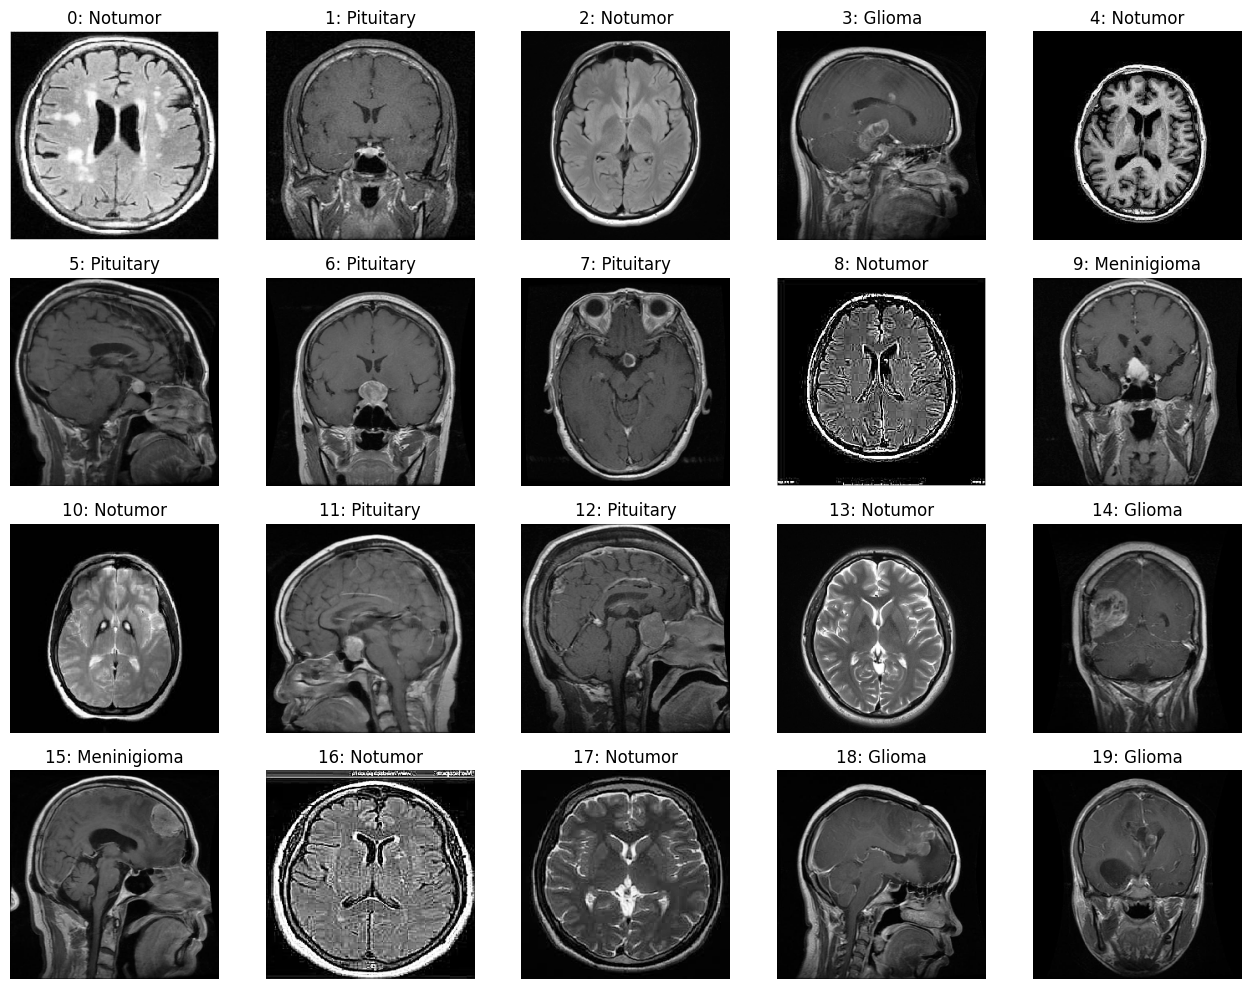

In [7]:
show_images(train_paths, train_index, class_mappings, im_size=250, figsize=(13,10),index_list=range(0, 20))

#### This function is to show how images are classified in both training and testing sets

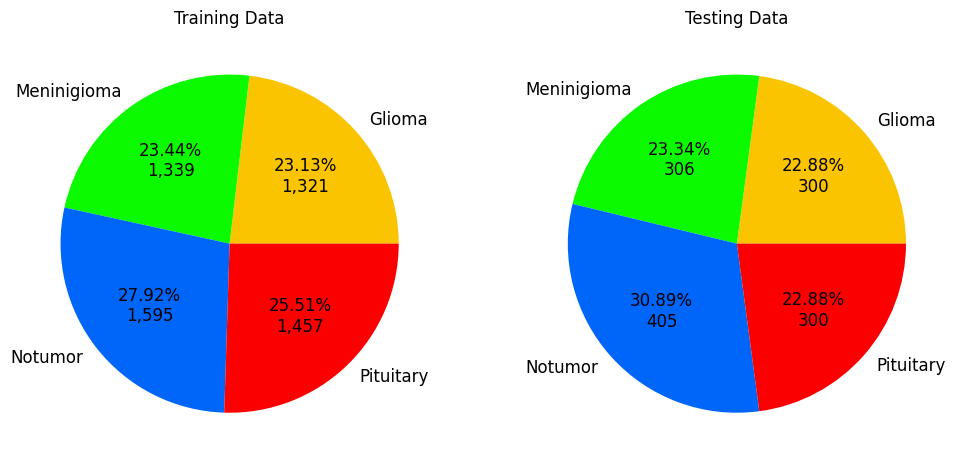

In [8]:
_, ax = plt.subplots(ncols=2, figsize=(12, 8))

class_counts = [len([x for x in train_index if x == label]) for label in set(train_index)]
ax[0].set_title('Training Data')
ax[0].pie(
    class_counts,
    labels=[label for label in class_names],
    colors=['#FAC500','#0BFA00', '#0066FA','#FA0000'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    textprops={'fontsize': 12}
)

class_counts = [len([x for x in test_index if x == label]) for label in set(test_index)]
ax[1].set_title('Testing Data')
ax[1].pie(
    class_counts,
    labels=[label for label in class_names],
    colors=['#FAC500', '#0BFA00', '#0066FA', '#FA0000'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    textprops={'fontsize': 12}
)

plt.show()

#### Sequential is used to define a linear stack of layers or a pipeline.
#### RandomRotation is used to rotate the images by a certain range of degrees during training.
#### RandomContrast is used to adjust the contrast of images randomly during training.
#### RandomZoom is used to apply random zoom-in or zoom-out transformations on the images.
#### RandomFlip is used to randomly flip the images horizontally, vertically, or both.
#### RandomTranslation is used to randomly shifting the image along the width and/or height axis.
#### Finally tf provides the TensorFlow library for deep learning, which includes Keras for model building, layer definitions, and training functionality.


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomContrast
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomTranslation
import tensorflow as tf

#### Here we preprocess the data we have 
#### In parse_function we decode the image data since at first it is in form of raw binary data our machine needs to decode it to process
#### By using this parse_function we PROCESS the image data and return the processed data in get_dataset 
#### It first combines paths and labels and create tensorflow dataset in path_ds as a tuple
#### After creating tuples in image_label_ds we called path_ds using lamda function which applies parse_function to each and every (path,label) tuple 
#### tf.data.autotune means it parallelizes the parse_funtion based on available hardware resources
#### then it returns the data after processing and resizing in batches and we store them in variables named train_ds and test_ds

In [10]:
def parse_function(filename, label, image_size, n_channels):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, n_channels)
    image = tf.image.resize(image, image_size)
    return image, label

def get_dataset(paths, labels, image_size, n_channels=1, num_classes=4, batch_size=32):
    path_ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    image_label_ds = path_ds.map(lambda path, label: parse_function(path, label, image_size, n_channels), num_parallel_calls=tf.data.AUTOTUNE)
    return image_label_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

batch_size = 32
image_dim = (128, 128)
train_ds = get_dataset(train_paths, train_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)
test_ds = get_dataset(test_paths, test_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)

### Untill now we get training dataset and testing dataset both with a similar size and in batches 
#### Now we did an augmentation on training dataset with several layers below
#### And also normalized the pixels value of an image to increase efficiency of a model for both training and test data
#### And these are mapped into new variables

In [11]:
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

def preprocess_train(image, label):
    image = data_augmentation(image) / 255.0
    return image, label

def preprocess_test(image, label):
    return image / 255.0, label

train_ds_preprocessed = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

#### A function to display these augmented images

In [12]:
def plot_augmented_images(dataset, shape, class_mappings, figsize=(13, 10)):
    plt.figure(figsize=figsize)
    index_to_class = {v: k for k, v in class_mappings.items()}
    for images, label in dataset.take(1):
        i = 0
        for i in range(shape[0]*shape[1]):
            ax = plt.subplot(shape[0], shape[1], i + 1)
            plt.imshow(images[i].numpy().squeeze(), cmap='gray')
            plt.title(index_to_class[label.numpy()[i]])
            plt.axis("off")
            i += 1

    plt.tight_layout()
    plt.show()

#### Augmented images from training dataset 

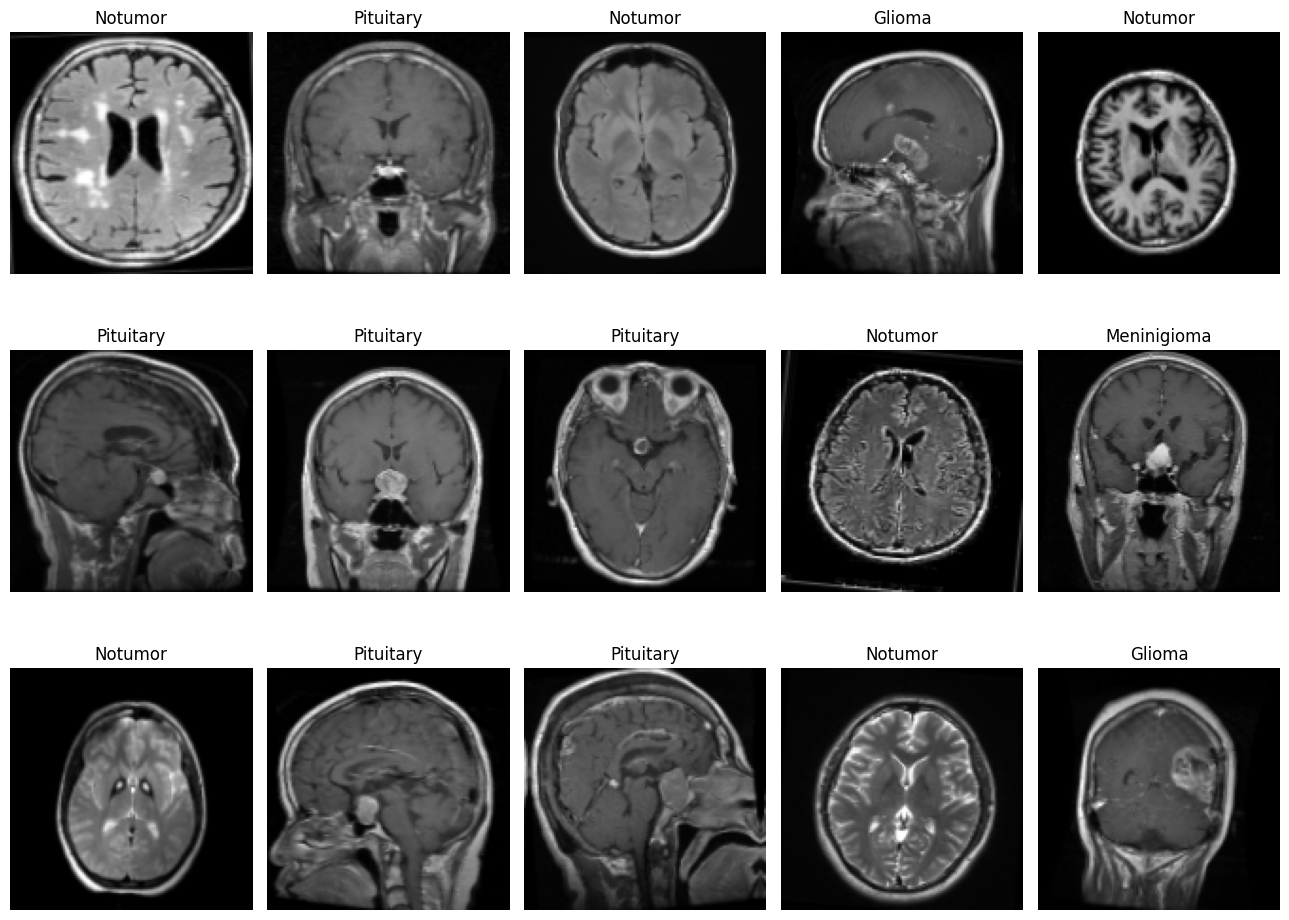

In [13]:
plot_augmented_images(train_ds_preprocessed, shape=(3, 5), class_mappings=class_mappings)

#### Here after Augmentation and Normalization on the images we apply one_hot encoding technique on labels of our data 
#### This makes our labels 0,1,2,3 as binary vectors [1,0,0,0],....,[0,0,0,1] 
#### This is used for multi class classification to calsify the image to a specific class through our model often using softmax activation funtion 

In [14]:
num_classes = len(class_mappings.keys())
image_shape = (image_dim[0], image_dim[1], 1)

epochs = 10
print(f'Number of Classes: {num_classes}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

def encode_labels(image, label):
    return image, tf.one_hot(label, depth=num_classes)

train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)

Number of Classes: 4
Image shape: (128, 128, 1)
Epochs: 10
Batch size: 32


In [15]:
image_height = 128
image_width = 128
channels = 1
num_classes = 4  

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(image_height, image_width, channels)),
    # First Convolutional Layer
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Second Convolutional Layer
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Third Convolutional Layer
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),

    # Fully Connected (Dense) Layers
    tf.keras.layers.Dense(128, activation='relu'),

    # Output layer
    tf.keras.layers.Dense(num_classes, activation='softmax')  
])

In [16]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,580 (12.61 MB)

 Trainable params: 3,304,580 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
image_height = 128
image_width = 128
channels = 1
num_classes = 4  

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(image_height, image_width, channels)),
    # First Convolutional Layer
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Second Convolutional Layer
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Third Convolutional Layer
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # LSTM and BILSTM Layers
    tf.keras.layers.Reshape((14 * 14, 128)),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),

    # Fully Connected (Dense) Layers
    tf.keras.layers.Dense(128, activation='relu'),

    # Output layer
    tf.keras.layers.Dense(num_classes, activation='softmax')  
])

In [18]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 196, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 196, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,156 (879.52 KB)

 Trainable params: 225,156 (879.52 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = model.fit(
    train_ds_preprocessed,
    validation_data=test_ds_preprocessed,
    epochs=10
)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 311s 2s/step - accuracy: 0.4783 - loss: 1.1111 - val_accuracy: 0.4996 - val_loss: 1.3417
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - accuracy: 0.7041 - loss: 0.7045 - val_accuracy: 0.5187 - val_loss: 1.2968
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.7250 - loss: 0.6511 - val_accuracy: 0.4729 - val_loss: 1.8023
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.7514 - loss: 0.6094 - val_accuracy: 0.6491 - val_loss: 0.8796
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 333s 2s/step - accuracy: 0.7870 - loss: 0.5432 - val_accuracy: 0.6934 - val_loss: 0.7697
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.8047 - loss: 0.4966 - val_accuracy: 0.6918 - val_loss: 0.8589
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.8091 - loss: 0.4906 - val_accuracy: 0.6400 - val_loss: 0.8788
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.8095 - loss: 0.4839 - val_accu

In [23]:
test_loss, test_acc = model.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_acc*100:0.4f}%")
print(f"Test loss: {test_loss*100:0.4f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 391ms/step - accuracy: 0.7664 - loss: 0.6178
Test accuracy: 76.0488%
Test loss: 62.6071%


In [24]:
prediction = model.predict(test_ds_preprocessed)

41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 416ms/step


In [25]:
import numpy as np

In [26]:
predicted_classes = np.argmax(prediction, axis=1)

In [27]:
predicted_classes

array([2, 0, 2, ..., 0, 2, 2])

#### We decoded the labels in our object to print and display them accordingly 

In [33]:
def decode_labels(image, label):
    return image, tf.argmax(label, axis=-1)

test_ds_decoded = test_ds_preprocessed.map(decode_labels)

#### To print the images using matplotlib first convert the tensorflow object into a numpy
#### And store the acctual labels and predicted labels 

In [ ]:
for images, labels in test_ds_decoded.take(1):  
    images_batch = images.numpy() 
    true_labels_batch = labels.numpy() 

actual_label_names = [index_to_class[label] for label in true_labels_batch] 
predicted_label_names = [index_to_class[predicted] for predicted in predicted_classes]  

#### Function used to display the predicted labels for the test data images with their actual labels for better understanding the performance of our model 

In [ ]:
def display_predictions(images, actual_labels, predicted_labels, class_mappings, index_list=range(10), im_size=128, figsize=(15, 10)):
    num_images = len(index_list)
    num_rows = (num_images + 4) // 5  
    _, ax = plt.subplots(nrows=num_rows, ncols=5, figsize=figsize)
    ax = ax.flatten() 

    for i, index in enumerate(index_list):
        if i >= num_images:
            break
        
        image = images[index].numpy().squeeze()  
        actual_class_name = index_to_class[actual_labels[index]]
        predicted_class_name = index_to_class[predicted_labels[index]]

        ax[i].imshow(image, cmap='Greys_r')
        ax[i].set_title(f'Actual: {actual_class_name}\nPredicted: {predicted_class_name}', fontsize=12)
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()

#### Calling that function to display our desired batches outcome in out test data

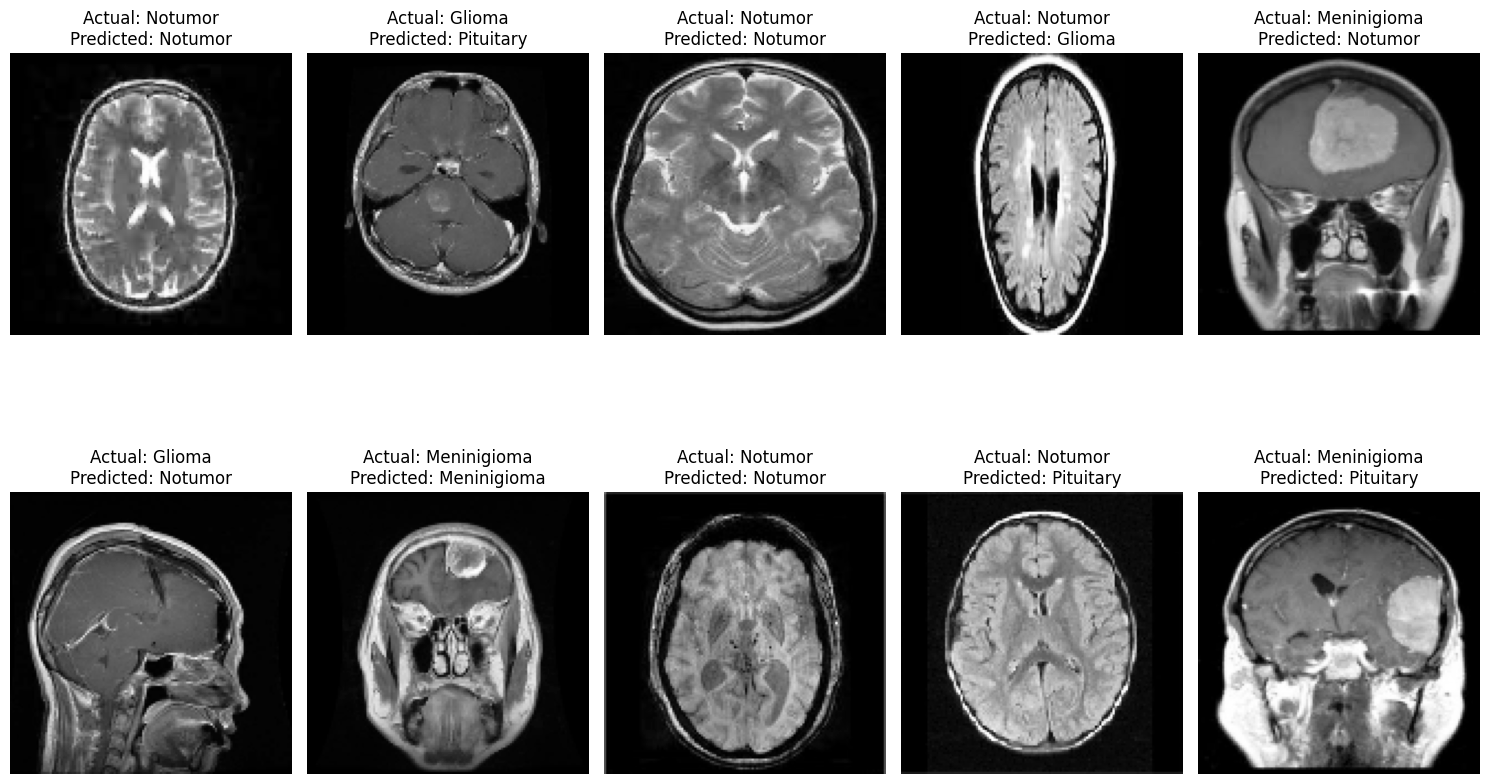

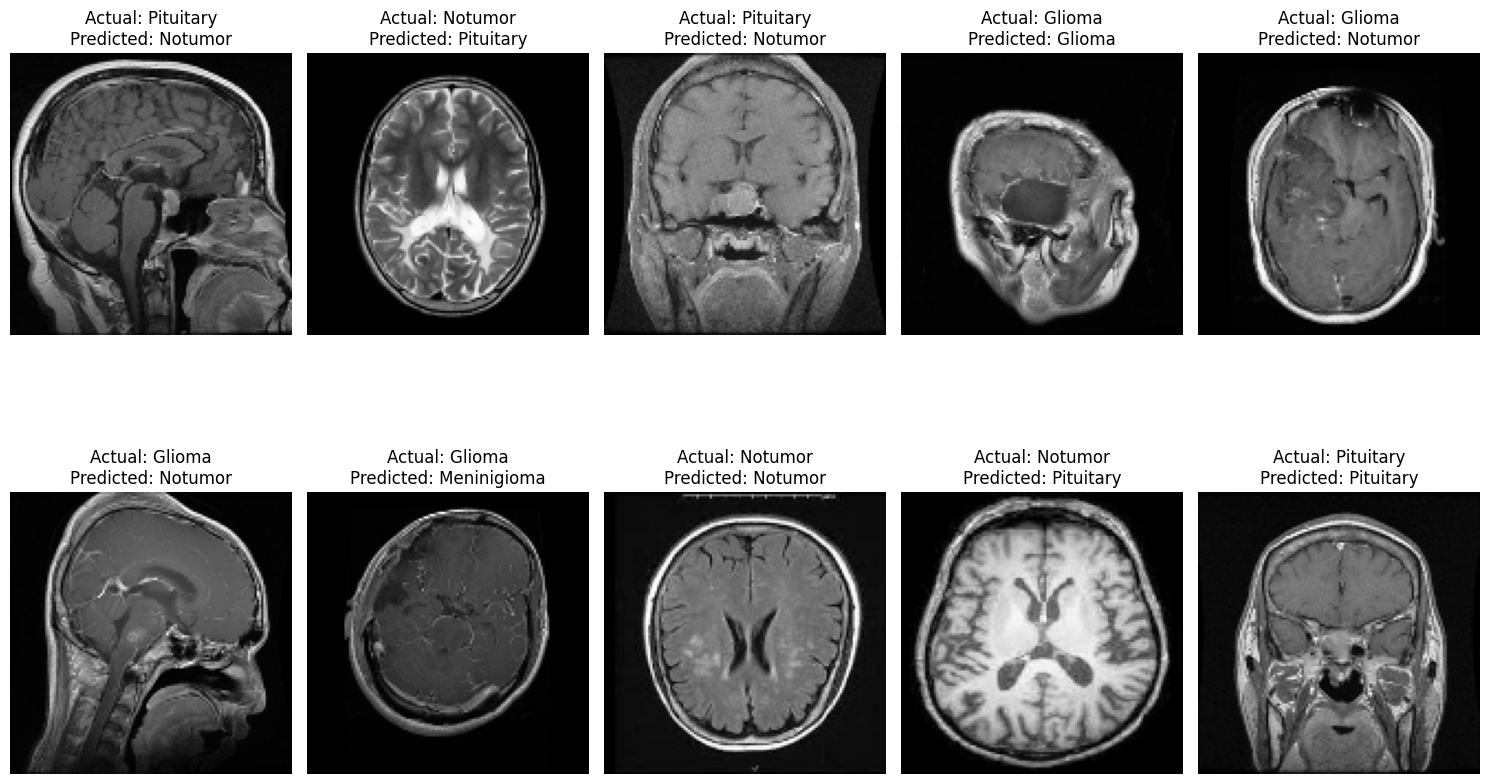

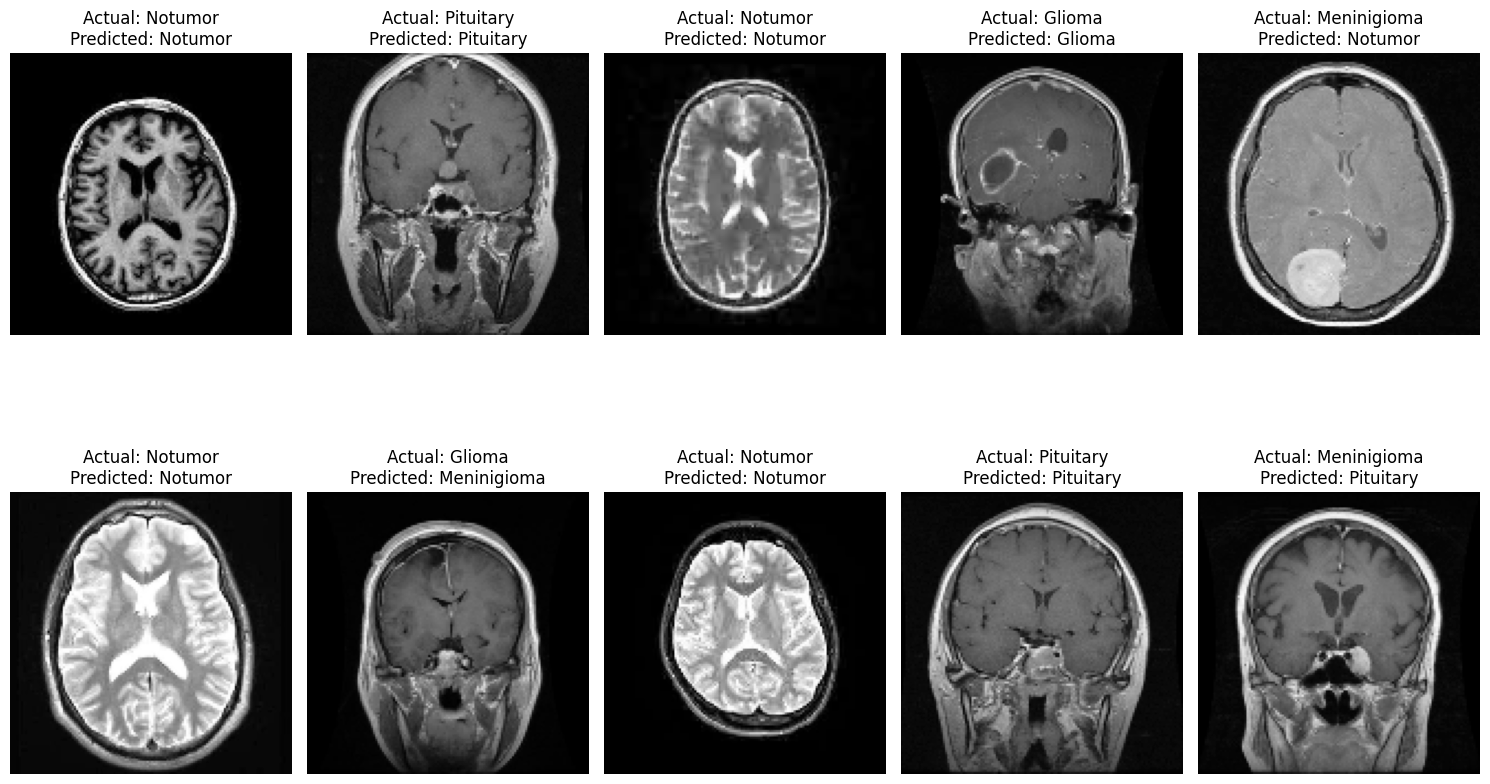

In [ ]:
for images, actual_labels in test_ds_decoded.take(3):
    display_predictions(
        images=images,
        actual_labels=actual_labels.numpy(),
        predicted_labels=predicted_classes,
        class_mappings=class_mappings,
        index_list=range(10),  
        im_size=128,  
        figsize=(15, 10)  
    )